In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BCS = 0.0
N_GRID_POINTS = 64
LAMBDA = 0.25
NU_DIFFUSION = 1.0 # [m^2/s]
STEPS = 100
SHOT_LIST =  [3000]
BATCH_SIZE = 1
REPETITIONS = 3

L_left = 0.0
L_right = 1.0
assert L_right > L_left, "L_right must be greater than L_left"

USE_FAKE_HARDWARE = True
NOISE = True

import qiskit, qiskit_aer
from qiskit.circuit import Instruction
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeBrisbane


print("Qiskit / Aer:", qiskit.__version__, qiskit_aer.__version__)

#
# Quantum Simulator
#
backend_ref = FakeBrisbane()
noise_model = NoiseModel.from_backend(backend_ref)

Qiskit / Aer: 2.2.1 0.17.2


In [2]:
def provide_simulator(noise=False):
    if USE_FAKE_HARDWARE == False:
        return AerSimulator()
    else:
        sim = AerSimulator.from_backend(backend_ref)
        sim.set_options(noise_model=None)
        if noise:
            sim.set_options(noise_model=noise_model)
    return sim

def angle_from_prob(p: float) -> float:
    """Return θ = 2*arcsin(sqrt(p)) with clipping to [0,1]."""
    p = float(np.clip(p, 0.0, 1.0))
    return 2.0 * np.arcsin(np.sqrt(p))

# ---------------------------
# Quantum branching micro-kernel
# ---------------------------
def branching_mk_instruction(uL, uC, uR, wL, wC, wR, name="node") -> Instruction:
    # angles
    theta0 = angle_from_prob(wR)
    left_mass = wL + wC
    thetaL = angle_from_prob(wC / left_mass)
    phiL, phiC, phiR = angle_from_prob(uL), angle_from_prob(uC), angle_from_prob(uR)

    # 3 qubits: [s0, s1, ro]
    sub = QuantumCircuit(3, name=name)

    sub.ry(theta0, 0)
    sub.x(0); sub.cry(thetaL, 0, 1); sub.x(0)

    sub.x(0); sub.x(1); sub.mcry(phiL, [0, 1], 2); sub.x(1); sub.x(0)
    sub.x(0); sub.mcry(phiC, [0, 1], 2); sub.x(0)
    sub.cry(phiR, 0, 2)

    return sub.to_instruction()

def build_batch(u: np.ndarray, lam: float, start_idx: int, batch_size: int, name="batch"):
    """
    Make one circuit containing up to M kernels for nodes i = start_idx .. start_idx+M-1 (clipped to N).
    Returns (circuit, node_indices) where node_indices are the interior node ids covered.
    """
    n_points = u.size - 2
    wL, wC, wR = lam, 1.0 - 2.0 * lam, lam

    # nodes that go into this batch
    nodes = list(range(start_idx, min(start_idx + batch_size, n_points + 1)))
    mm = len(nodes)

    q = QuantumRegister(3 * mm, "q")
    c = ClassicalRegister(mm, "c")
    circ = QuantumCircuit(q, c, name=name)

    for j, i in enumerate(nodes):
        s0 = 3 * j
        s1 = s0 + 1
        ro = s0 + 2
        inst = branching_mk_instruction(u[i - 1], u[i], u[i + 1], wL, wC, wR, name=f"node_{i}")
        circ.append(inst, [q[s0], q[s1], q[ro]])
    ro_qubits = [q[3*j + 2] for j in range(mm)]
    circ.measure(ro_qubits, c[:mm])
    return circ, nodes

def one_step_diffusion_eq_batched(u: np.ndarray, lam: float, shots: int, batch_size: int, sim=None) -> np.ndarray:
    if sim is None:
        sim = provide_simulator()

    n_points = u.size - 2
    u_new = np.ones_like(u) * BCS

    # build all batch circuits first
    batches = []
    idx_groups = []
    for start in range(1, n_points + 1, batch_size):
        bc, nodes = build_batch(u, lam, start, batch_size, name=f"batch_{start}")
        batches.append(bc)
        idx_groups.append(nodes)

    # transpile & run as a list
    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)
    result = sim.run(tbatches, shots=shots).result()

    # P(bit j == '1') from raw counts of an m-bit circuit, invert endianess (Qiskit is little-endian)
    # Usefull is batch_size>1 is used
    def p1_from_counts(counts, m, j):
        total = 0
        for s, n in counts.items():
            s = s.zfill(m)
            if s[::-1][j] == '1':
                total += n
        return total / shots

    for k, nodes in enumerate(idx_groups):
        counts = result.get_counts(k)
        m = len(nodes)
        for j, i in enumerate(nodes):
            u_new[i] = p1_from_counts(counts, m, j)

    return u_new


def get_circuit_info(u: np.ndarray, lam: float, batch_size: int, sim=None):
    if sim is None:
        sim = provide_simulator()

    n_points = u.size - 2
    # build all batch circuits first
    batches = []
    idx_groups = []
    for start in range(1, n_points + 1, batch_size):
        bc, nodes = build_batch(u, lam, start, batch_size, name=f"batch_{start}")
        batches.append(bc)
        idx_groups.append(nodes)

    # transpile
    tbatches = transpile(batches, backend=sim, optimization_level=3, seed_transpiler=42)
    metrics = []
    for k, qc in enumerate(tbatches):
        # Basic info
        n_qubits  = qc.num_qubits
        n_clbits  = qc.num_clbits
        size      = qc.size()                 # total instructions
        depth     = qc.depth()                # includes measure/barrier
        depth_nom = qc.depth(                 # ignore measure/barrier
            filter_function=lambda inst: inst.operation.name not in ("measure", "barrier")
        )
        ops = qc.count_ops() 
        metrics.append({
            "batch": k,
            "name": qc.name,
            "nodes": list(idx_groups[k]),
            "n_qubits": n_qubits,
            "n_clbits": n_clbits,
            "size": size,
            "depth": depth,
            "depth_no_meas": depth_nom,
            "ops": dict(ops)
        })

    # Print metrics
    for m in metrics:
        print(
            f"{m['name']}: depth={m['depth']} (no-meas {m['depth_no_meas']}), "
            f"size={m['size']}, qubits={m['n_qubits']}, operations={m['ops']}")

In [3]:
def convergence_test(N=65, lam=0.25, steps=47, shots_list=(1000,4000,8000,16000,32000), repetitions=10, nu=1.0,
                     one_step_circuit=one_step_diffusion_eq_batched, noise=False):
    
    u_noise = None
    
    sim = provide_simulator(noise=noise)
    dx = (L_right - L_left) / (N + 1)
    dt = lam * dx * dx / nu # CFL condition
    # dt in [s]
    
    time_array = np.zeros(steps)

    x = np.linspace(L_left, L_right, N+2)
    u_analytic = np.zeros(N+2) + BCS

    T = steps * dt
    u_analytic[1:-1] = np.exp(-nu * (np.pi**2) * T) * np.sin(np.pi * x[1:-1]) + BCS
    
    print(f"\nConvergence test: N={N}, steps={steps}, λ={lam}, ν={nu}, dx={dx:.6g}, dt={dt:.6g}, T={T:.6g}")
    
    # print qc metrics
    u = np.zeros(N+2) + BCS
    u[1:-1] = np.sin(np.pi * x[1:-1]) + BCS
    get_circuit_info(u, lam, batch_size=BATCH_SIZE, sim=sim)

    profiles_for_plot = {}
    L_inf_tot = []
    L2_tot = []

    all_errors = {}
    all_profiles_time = {}

    for ss in shots_list:
        L_inf = []
        L2 = []

        Linf_vec = []
        L2_vec = []

        for r in range(repetitions):
            # Initial condition u(x,0)=sin(pi x)
            u = np.zeros(N+2) + BCS
            u[1:-1] = np.sin(np.pi * x[1:-1]) + BCS

            u_analytic_time = np.zeros(N+2) + BCS
            
            print(f"Diffusion: shots={ss}, rep={r+1}/{repetitions}")

            u_time_matrix = np.zeros((steps, N+2))
            u_time_analytic_matrix = np.zeros((steps, N+2))

            for i in range(steps):
                if i % (steps // 20) == 0:
                    print("Step ", i+1, "/",steps)

                time_array[i] += i*dt / repetitions
                    
                u = one_step_circuit(u, lam, shots=ss, batch_size=BATCH_SIZE, sim=sim)
                u_time_matrix[i,:] = u.copy()

                u_analytic_time[1:-1] = np.exp(-nu * (np.pi**2) * (i*dt)) * np.sin(np.pi * x[1:-1])
                u_time_analytic_matrix[i,:] = u_analytic_time.copy()

            # errors
            diff = u[1:-1] - u_analytic[1:-1]
            linf = np.max(np.abs(diff))
            l2 = np.sqrt(np.mean(diff**2))
            L_inf.append(linf)
            L2.append(l2)

            diff_matrix = u_time_matrix - u_time_analytic_matrix
            linf_vec = np.max(np.abs(diff_matrix), axis=1)
            l2_vec = np.sqrt(np.mean(diff_matrix**2, axis=1))
            Linf_vec.append(linf_vec)
            L2_vec.append(l2_vec)

            if r == 0:
                profiles_for_plot[ss] = u.copy()
                all_profiles_time[ss] = (u_time_matrix.copy(), u_time_analytic_matrix.copy())

        L_inf_tot.append(L_inf)
        L2_tot.append(L2)

        print(f"{ss:<9d} {np.mean(L_inf):.4f} ± {np.std(L_inf):.4f}  {np.mean(L2):.4f} ± {np.std(L2):.4f}")

        Linf_vec = np.array(Linf_vec)
        L2_vec = np.array(L2_vec)
        mean_L_inf_time = np.mean(Linf_vec, axis=0)
        std_L_inf_time = np.std(Linf_vec, axis=0)
        mean_L2_time = np.mean(L2_vec, axis=0)
        std_L2_time = np.std(L2_vec, axis=0)

        all_errors[ss] = {
            'mean_L_inf_time': mean_L_inf_time,
            'std_L_inf_time': std_L_inf_time,
            'mean_L2_time': mean_L2_time,
            'std_L2_time': std_L2_time
        }

    return {
        'x': x,
        'u_analytic': u_analytic,
        'profiles_for_plot': profiles_for_plot,
        'all_profiles_time': all_profiles_time,
        'all_errors': all_errors,
        'time': time_array,
        'shots_list': shots_list,
        'steps': steps,
        'u_noise': u_noise
    }

convergence_results = convergence_test(N=N_GRID_POINTS, lam=LAMBDA, steps=STEPS,
                    shots_list=SHOT_LIST, repetitions=REPETITIONS, nu=NU_DIFFUSION, 
                    one_step_circuit=one_step_diffusion_eq_batched, noise=NOISE)



Convergence test: N=64, steps=100, λ=0.25, ν=1.0, dx=0.0153846, dt=5.91716e-05, T=0.00591716
batch_1: depth=166 (no-meas 165), size=247, qubits=127, operations={'rz': 128, 'sx': 65, 'ecr': 42, 'x': 11, 'measure': 1}
batch_2: depth=169 (no-meas 168), size=250, qubits=127, operations={'rz': 128, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_3: depth=166 (no-meas 165), size=249, qubits=127, operations={'rz': 127, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_4: depth=167 (no-meas 166), size=250, qubits=127, operations={'rz': 128, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_5: depth=165 (no-meas 164), size=249, qubits=127, operations={'rz': 127, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_6: depth=166 (no-meas 165), size=251, qubits=127, operations={'rz': 129, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_7: depth=169 (no-meas 168), size=251, qubits=127, operations={'rz': 129, 'sx': 69, 'ecr': 42, 'x': 10, 'measure': 1}
batch_8: depth=167 (no-meas 166), size=250, q

In [4]:
# system Tau for Heat L^2 / nu
tau = (L_right - L_left)**2 / NU_DIFFUSION

print(f"System time scales for Heat equation:")
print(f"  Diffusive time scale: tau = {tau:.4g} s")

System time scales for Heat equation:
  Diffusive time scale: tau = 1 s


<>:29: SyntaxWarning: invalid escape sequence '\i'
<>:29: SyntaxWarning: invalid escape sequence '\i'
/var/folders/9f/_xx5w7bj79b0pd_wr2l27y000000gn/T/ipykernel_99138/2456932248.py:29: SyntaxWarning: invalid escape sequence '\i'
  plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)


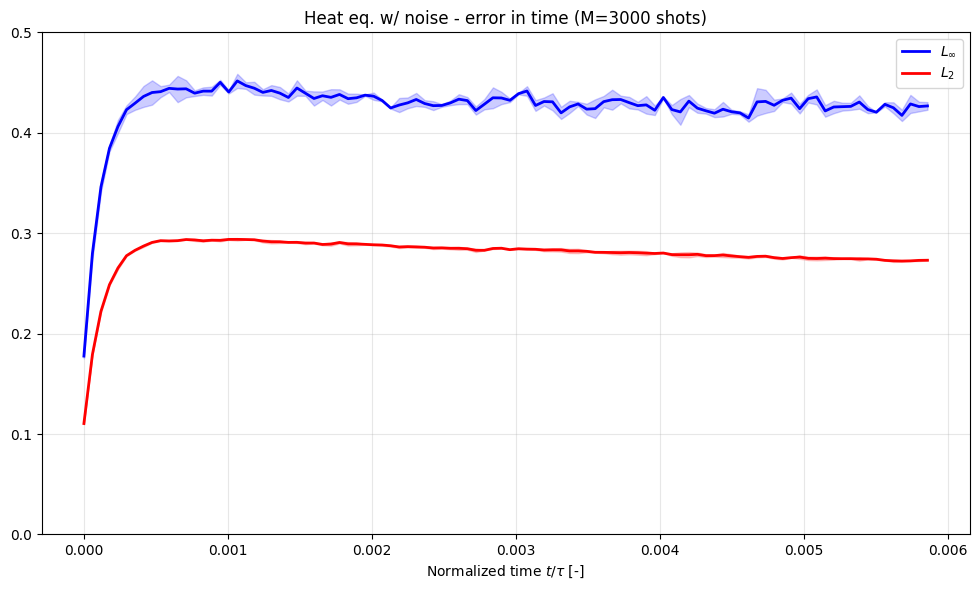

In [13]:
# plot on time_step
# plot on physical normalized time "t/tau"

normalize_time = True
physical_time = False

for ss in convergence_results['shots_list']:
    errors = convergence_results['all_errors'][ss]
    mean_L_inf_time = errors['mean_L_inf_time']
    std_L_inf_time = errors['std_L_inf_time']
    mean_L2_time = errors['mean_L2_time']
    std_L2_time = errors['std_L2_time']
    steps = convergence_results['steps']

    if normalize_time:
        time_array = convergence_results['time']
        time_plot = time_array / tau
        string = "Normalized time $t / \\tau$ [-]"
    elif physical_time:
        time_plot = convergence_results['time']
        string = "Physical time $t$ [s]"
    else:
        time_plot = range(1, steps+1)
        string = "Time steps"

    plt.figure(figsize=(10, 6))
    plt.title(f"Heat eq. w/ noise - error in time (M={ss} shots)")
    plt.xlabel(f"{string}")
    plt.plot(time_plot, mean_L_inf_time, label="$L_\infty$", color='blue', linewidth=2)
    plt.fill_between(time_plot, mean_L_inf_time - std_L_inf_time, 
                     mean_L_inf_time + std_L_inf_time, alpha=0.2, color='blue')
    plt.plot(time_plot, mean_L2_time, label="$L_2$", color='red', linewidth=2)
    plt.fill_between(time_plot, mean_L2_time - std_L2_time, 
                     mean_L2_time + std_L2_time, alpha=0.2, color='red')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.ylim([0, 0.5])
    plt.show()

<Figure size 1200x700 with 0 Axes>

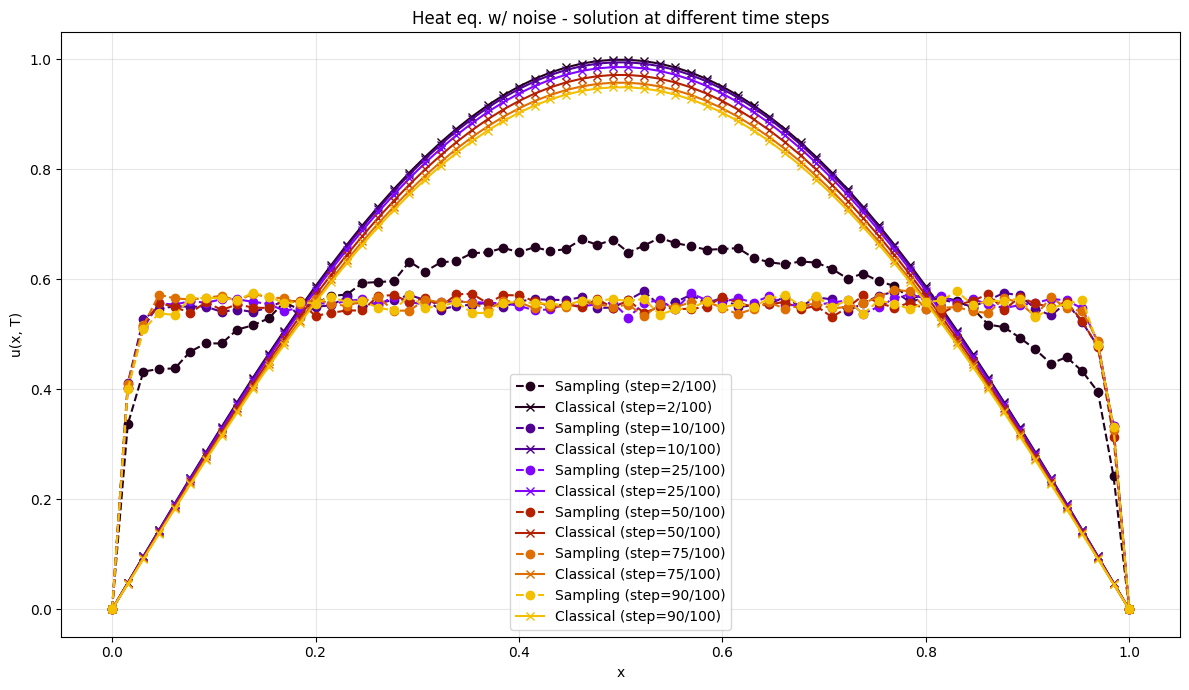

In [14]:
percentage_list = [2, 10, 25, 50, 75, 90]

x = convergence_results['x']
shots_list = convergence_results['shots_list']

# Use first shot configuration for illustration
for ss in convergence_results['shots_list']:
    # u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][ss]

    data = convergence_results['all_profiles_time'].get(ss, None)
    if data is not None:
        u_time_matrix, u_time_analytic_matrix = data
    else:
        print(f"No profile data for shots={ss}, skipping plot.")
        continue
    
    steps = convergence_results['steps']

    colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
    plt.figure(figsize=(12, 7))
    plt.figure(figsize=(12, 7))
    for percentage in percentage_list:
        step = int(round((percentage / 100) * steps))
        plt.plot(x[:], u_time_matrix[step, :], color=colorlist[step], linestyle='--', 
                marker="o", label=f"Sampling (step={step}/{steps})")
        plt.plot(x[:], u_time_analytic_matrix[step, :], color=colorlist[step], 
                marker="x", label=f"Classical (step={step}/{steps})")
    plt.xlabel("x")
    plt.ylabel("u(x, T)")
    plt.title(f"Heat eq. w/ noise - solution at different time steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

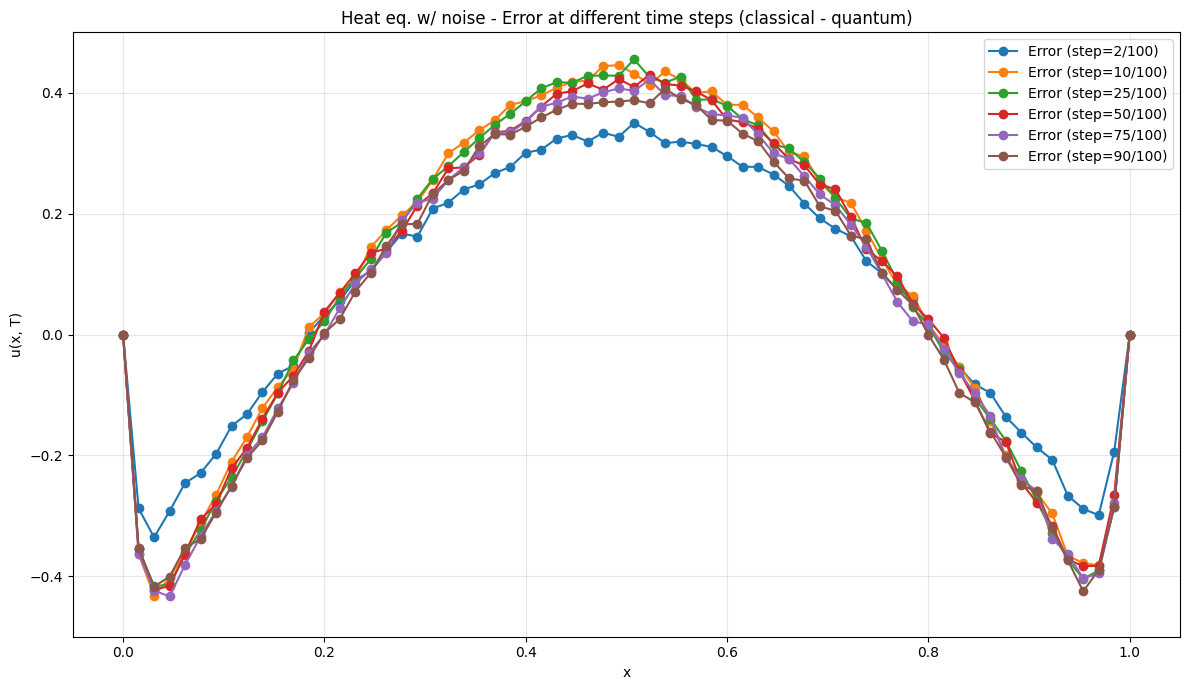

In [15]:
x = convergence_results['x']
shots_list = convergence_results['shots_list']
M = shots_list[0]
u_time_matrix, u_time_analytic_matrix = convergence_results['all_profiles_time'][M]
steps = convergence_results['steps']

# colorlist = plt.cm.gnuplot(np.linspace(0, 1, steps))
plt.figure(figsize=(12, 7))
for percentage in percentage_list:
    step = int(round((percentage / 100) * steps))
    plt.plot(x[:], u_time_analytic_matrix[step, :]- u_time_matrix[step, :], 
             marker="o", label=f"Error (step={step}/{steps})")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.title(f"Heat eq. w/ noise - Error at different time steps (classical - quantum)")
# plt.plot(x[:], np.sinc((4*x)-2) * 0.3, linestyle='--', color='black', label="Sync reference")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.ylim([-0.5, 0.5])
plt.show()

In [8]:
# plot u_noise
u_noise = convergence_results['u_noise']

if u_noise is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(x[:], u_noise[:], marker='o', linestyle='--', label="u_noise")
    plt.xlabel("x")
    plt.ylabel("u_noise")
    plt.title(f"Noise component after filtering (CUTOFF={CUTOFF})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()